# Only Fine Structure (Movre Pischler) Reorganized

In [1]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display
from IPython.display import Latex
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import Latex

import matplotlib as mpl
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
import MoleculeCalculation as mol

# Work

In [2]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [3]:
lsToJOp = mol.create_lsiToJi_Op(lsiBasis,jiBasis)
fsOperator = mol.create_fsH(jiBasis2Atom)#fsOp(jiBasis2Atom)

In [4]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


In [5]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


## Create Symmetrized Fine Structure Hamiltonians

In [6]:
def createCaseABasis_Sym(Lvals, Svals, ivals, I_BOvals=["g","u"], Jv=None, Fv=None):
    boBasisRef = []
    for I_BO in I_BOvals:
        for L_ in Lvals:
            for Lambda in np.arange(-L_,L_+1,1):
                for S_ in Svals:
                    for Sigma in np.arange(-S_, S_+1,1):
                        Omega = Sigma+Lambda
                        Phi  = Sigma+Lambda
                        if Lambda != 0 and Omega==0: # Pi and Omega == 0 so Sigma = 1 and two ways of symmetrizing.
                            for kappa_FS in [-1,1]:
                                state = mol.multiplyableDict({"L":L_, "|Lambda|": abs(Lambda), 
                                                          "I_BO": I_BO, "S":S_, "|Sigma|":abs(Sigma),
                                                          "|Omega|":abs(Omega),
                                                          "kappa_FS": kappa_FS})
                                if state not in boBasisRef:
                                    boBasisRef.append(state)
                        else:
                            state = mol.multiplyableDict({"L":L_, "|Lambda|": abs(Lambda), 
                                                      "I_BO": I_BO, "S":S_, "|Sigma|":abs(Sigma), 
                                                      "|Omega|":abs(Omega),
                                                      "kappa_FS": (-1)**(L_-Lambda+S_-Sigma)})
                            if state not in boBasisRef:
                                boBasisRef.append(state)
    boBasisRef = list(sorted(boBasisRef, key=lambda state: abs(state["|Omega|"])))
    return boBasisRef

In [7]:
from copy import copy

In [17]:
def createExpandedCaseABasis(boBasis):
    expandedBasis = []
    for state in boBasis:
        for Sigma in np.arange(-state['S'], state['S']+1,1):
            Omega = Sigma+state['|Lambda|']
            if state['|Lambda|'] != 0 and Omega==0: 
                # Pi state and Omega == 0 so Sigma = 1 and two ways of symmetrizing.
                for kappa_FS in [-1,1]:
                    newState = copy(state)
                    newState.update({"|Sigma|":abs(Sigma), 'kappa_BO':kappa_FS, '|Omega|':abs(Omega)})
                    expandedBasis.append(newState)
            elif Sigma>=0:
                kappa_FS=(-1)**(1-state['|Lambda|']+state['S']-Sigma)
                newState = copy(state)
                newState.update({"|Sigma|":abs(Sigma), 'kappa_BO':kappa_FS, '|Omega|':abs(Omega)})
                if newState not in expandedBasis:
                    expandedBasis.append(newState)
                else:
                    print('!',newState)
    return expandedBasis

In [20]:
boStates = [
    {"|Lambda|":0, "S":1, "I_BO":'g', "kappa_BO":1},
    {"|Lambda|":0, "S":1, "I_BO":'u', "kappa_BO":1},
    {"|Lambda|":0, "S":0, "I_BO":'g', "kappa_BO":1},
    {"|Lambda|":0, "S":0, "I_BO":'u', "kappa_BO":1},
    {"|Lambda|":1, "S":1, "I_BO":'g' },
    {"|Lambda|":1, "S":1, "I_BO":'u' },
    {"|Lambda|":1, "S":0, "I_BO":'g' },
    {"|Lambda|":1, "S":0, "I_BO":'u' },
]
expandedBOBasis = createExpandedCaseABasis(boStates)

In [43]:
for state in expandedBOBasis: # to work with hfs code
    state.update({'L':1,'|Iota|':0,'I':0,'i_a':0,'i_b':0,'Phi':state['|Omega|'], 'kappa_HFS':state['kappa_BO']})

In [32]:
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u'])

In [33]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega):
            if Omega == 0:
                parityString = '+' if state['kappa_BO'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)

### All Omega

In [45]:
def caseASymHfsToMostlySym(state, mostlySymBasis, indexes=False):
    # this is one of my weird transformations that I want to revise to be a normal matrix.         
    if state['|Omega|'] == 0 and state['|Iota|'] == 0:
        return caseASymFsToMostlySym(state, mostlySymBasis, indexes=indexes)
    else:
        stateMostlySym1, stateMostlySym2 = {},{}        
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS", "|Lambda|", "|Sigma|", "|Omega|"]:
                pass
            elif key[0] != "|":
                stateMostlySym1[key] = state[key]
                stateMostlySym2[key] = state[key]
            elif key == "Phi":
                stateMostlySym1["Phi"] = state["Phi"]
            elif key == "|Iota|":
                if (state['|Iota|'] + state['|Omega|'] == state["Phi"]) or (state['|Iota|'] - state['|Omega|'] == state["Phi"]):
                    IotaSign = 1
                else:
                    IotaSign = -1
                stateMostlySym1["Iota"] = IotaSign*state["|Iota|"]
        
        stateMostlySym1['Omega'] = stateMostlySym1['Phi'] - stateMostlySym1['Iota']
        stateMostlySym1['Lambda'] = (1 if stateMostlySym1['Omega']>0 else -1)*state['|Lambda|']
        stateMostlySym1['Sigma'] = stateMostlySym1['Omega'] - stateMostlySym1['Lambda']
        for key in ['Phi','Iota','Omega','Lambda','Sigma']:
            stateMostlySym2[key] = -stateMostlySym1[key]        
                
        # Im confused about why this seems to need to involve kappa_BO to work.
        sign = '+' if state['kappa_HFS']*state['kappa_BO']*(-1)**(state['I']-state['|Iota|'])==1 else '-'
        #sign = '+' if state['kappa_HFS']*(-1)**(state['I']-state['|Iota|'])==1 else '-'
        #sign = '+' if state['kappa_HFS'] == 1 else '-'
        if indexes:
            return [mostlySymBasis.index(stateMostlySym1), mostlySymBasis.index(stateMostlySym2)], [1,1 if sign == "+" else -1]
        return '|'+''.join([str(val) for key, val in stateMostlySym1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateMostlySym2.items()])+'>'


In [46]:
def caseASymFsToMostlySym(state, mostlySymBasis, indexes=False):
    # this is one of my weird transformations that I want to revise to be a normal matrix. 
    if state['|Lambda|'] == 0 and state['|Sigma|'] == 0:
        stateMostlySym = {}
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS"]:
                pass
            elif key == '|Iota|':
                stateMostlySym['Iota'] = state['Phi']
            elif key[0] != "|":
                stateMostlySym[key] = state[key]
            else:
                stateMostlySym[key[1:-1]] = 0
        if indexes:
            return [mostlySymBasis.index(stateMostlySym)], [1]
        return '|'+''.join([str(val) for key, val in stateMostlySym.items()])+'>'
    else:
        # else two state contribute
        stateMostlySym2, stateMostlySym1 = {}, {}
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS"]:
                pass
            elif key[0] != "|":
                stateMostlySym1[key] = state[key]
                stateMostlySym2[key] = state[key]
            elif key == "|Lambda|":
                stateMostlySym1[key[1:-1]] = state[key]
                stateMostlySym2[key[1:-1]] = -state[key]
            elif key == "|Sigma|":
                stateMostlySym1[key[1:-1]] = state["|Omega|"] - stateMostlySym1['Lambda']
                stateMostlySym2[key[1:-1]] = -state["|Omega|"] - stateMostlySym2['Lambda']
            elif key == "|Omega|":
                stateMostlySym1["Omega"] = state["|Omega|"]
                stateMostlySym2["Omega"] = -state["|Omega|"]
            elif key == "Phi":
                stateMostlySym1["Phi"] = state["Phi"]
                stateMostlySym2["Phi"] = -state["Phi"]
            elif key == "|Iota|":
                stateMostlySym1["Iota"] = state["Phi"]-state["|Omega|"]
                stateMostlySym2["Iota"] = state["Phi"]-(-state["|Omega|"])
        sign = '+' if state['kappa_BO'] == 1 else '-'
        if indexes:
            return [mostlySymBasis.index(stateMostlySym1), mostlySymBasis.index(stateMostlySym2)], [1,1 if sign == "+" else -1]
        return '|'+''.join([str(val) for key, val in stateMostlySym1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateMostlySym2.items()])+'>'

In [ ]:
def caseAToAtomic( oalNums, spinNums, nuclearNums, I_BO, lsiBasis, basisChange=None ):
    """
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, Iota, ia, ib) = nuclearNums
    first converts to lsi basis then to whatever basis determined by basischange.
    
    this is the place to focus next. 
    """
    
    state = 0
    otherBasisStates, lsiBasisStates, indvCont = [], [], []
    (L, Lambda, la, lb) = oalNums
    (S, Sigma, sa, sb) = spinNums
    (I, Iota, ia, ib) = nuclearNums
    p_ = (-1)**(S+I_BO)
    for mla in np.arange(-la,la+1,1):
        mlb = Lambda-mla
        if abs(mlb) > lb:
            continue
        for msa in np.arange(-sa,sa+1,1):
            msb = Sigma-msa
            if abs(msb) > sb:
                continue
            for mia in np.arange(-ia, ia+1, 1):
                mib = Iota-mia
                if abs(mib) > ib:
                    continue
                # for mib in np.arange(-ib,ib+1,1):
                # CG notation is <j_a,mj_a,j_b,mj_b|j3,mj3>
                oalCoef = float(CG(la,mla,lb,mlb,L,Lambda).doit())
                spinCoef = float(CG(sa,msa,sb,msb,S,Sigma).doit())
                nuclearCoef = float(CG(ia,mia,ib,mib,I,Iota).doit())
                aState1 = getColumnState(lsiBasis, {'l_x':la,'m_l_x':mla,'s_x':sa,'m_s_x':msa, 'i_x':ia,'m_i_x':mia})
                bState1 = getColumnState(lsiBasis, {'l_x':lb,'m_l_x':mlb,'s_x':sb,'m_s_x':msb, 'i_x':ib,'m_i_x':mib})
                aState2 = getColumnState(lsiBasis, {'l_x':lb,'m_l_x':mlb,'s_x':sa,'m_s_x':msa, 'i_x':ia,'m_i_x':mia})
                bState2 = getColumnState(lsiBasis, {'l_x':la,'m_l_x':mla,'s_x':sb,'m_s_x':msb, 'i_x':ib,'m_i_x':mib})
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    lsiBasisStates.append([aState1, bState1, aState2, bState2])
                if basisChange is not None:
                    aState1 = basisChange@aState1
                    bState1 = basisChange@bState1
                    aState2 = basisChange@aState2
                    bState2 = basisChange@bState2
                newpart = nuclearCoef*oalCoef*spinCoef * (np.kron(aState1,bState1) + p_ * np.kron(aState2,bState2))
                state += newpart
                if oalCoef != 0 and nuclearCoef != 0 and spinCoef != 0:
                    indvCont.append(newpart)
                    otherBasisStates.append([aState1, bState1, aState2, bState2])
    if np.linalg.norm(state) == 0:
        raise ValueError("State has zero norm!")
    state /= np.linalg.norm(state)
    return state

In [48]:
def genCaseAToLsiTransform(caseABasis, lsiBasis):
    pass

In [36]:
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
#for label, base in zip(['1g'],[symmetrizedBases['1g']]):
    #IPython.display.clear_output(wait=True)
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    fsStates, hfsStates = [],[]
    for num, state in enumerate(base):
        misc.reportProgress(num, len(base))
        indexes, signs = mol.caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
        symHfsState, symFsState = 0, 0
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.
        print(indexes, signs)
        if state['|Omega|'] != 0:
            indexes = [indexes[0]]
            signs = [signs[0]]
        for index, sign in zip(indexes,signs):
            caseAState = caseAMostlySymHfs[index] # alias
            I_BO = mol.g if caseAState["I_BO"] == "g" else mol.u
            #nuclearNums = [caseAState['I'], caseAState['Iota'],caseAState['i_a'],caseAState['i_b']]
            oalNums = (caseAState["L"], caseAState["Lambda"], 1, 0) # oal = "orbital angular momentum"
            spinNums = (caseAState["S"], caseAState["Sigma"], 1/2, 1/2)
            symFsState += sign * mol.caseAToAtomic( oalNums, spinNums, (0,0,0,0), I_BO, lsiBasis, basisChange=lsToJOp )
        fsStates.append(symFsState / np.sqrt(len(indexes)));
    # now that I know the atomic representation of all the caseA states, 
    # I can create the fine structure and hyperfine structure hamiltonian for this set of caseA states. 
    H_fs_phi[label] = mol.convertH_toCaseABasis( fsStates, fsOperator * 2 * DeltaVal / 3, offset = -1/2* 2 * E_FS_5P12_5P32 / 3)

Working on states of symmetry 0+g. 2 states
[1] [1]                   
[5, 4] [1, 1]             
Working on states of symmetry 0+u. 2 states
[3] [1]                   
[7, 6] [1, 1]             
Working on states of symmetry 0-g. 2 states
[0] [1]                   
[5, 4] [1, -1]            
Working on states of symmetry 0-u. 2 states
[2] [1]                   
[7, 6] [1, -1]            
Working on states of symmetry 1g. 3 states
[17, 16] [1, 1]           
[11, 9] [1, 1]            
[10, 8] [1, 1]            
Working on states of symmetry 1u. 3 states
[19, 18] [1, 1]           
[15, 13] [1, 1]           
[14, 12] [1, 1]           
Working on states of symmetry 2g. 1 states
[21, 20] [1, 1]           
Working on states of symmetry 2u. 1 states
[23, 22] [1, 1]           


In [37]:
print(np.linalg.eig(H_fs_phi['0+g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0+u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2g']*1e-9/mc.h)[0])

[   -0.    -7123.021]
[   -0.    -7123.021]
[   -0.    -7123.021]
[   -0.    -7123.021]
[-7123.021     0.        0.   ]
[-7123.021     0.        0.   ]
[-0.]
[-0.]


## Results

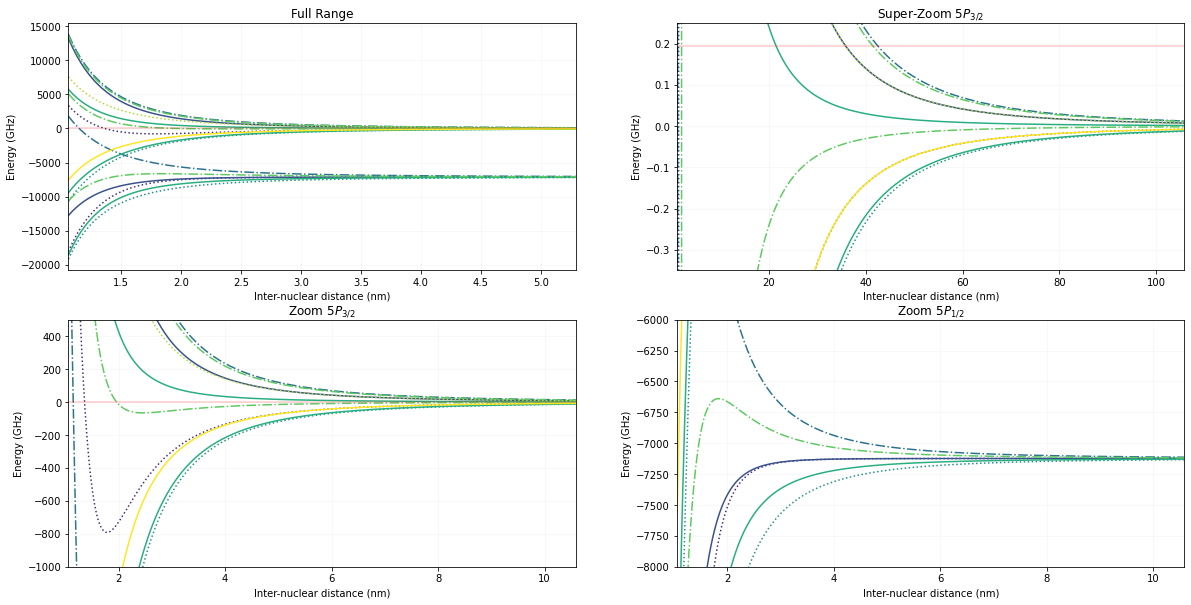

In [39]:
fig, axs = plt.subplots(2,2,figsize=(20,10))
Rvals = np.linspace( 20*mc.a0, 2000*mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.set_xlabel('Inter-nuclear distance (nm)')
    ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[0,0].set_title('Full Range')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
#axs[0,0].legend(ncol=5,fontsize=14)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)